<a href="https://colab.research.google.com/github/KenLo506/income_predictor/blob/main/incomepredictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Part 0: Load Data



In [ ]:

import os
import pandas as pd
import numpy as np


census_column_names=['age','workclass','fnlwgt','education','education-num',
                      'marital-status','occupation','relationship','race','sex',
                      'capital-gain','capital-loss','hours-per-week','native-country',
                      'annual-income']

CENSUS_PATH="datasets"

def load_census_data(census_path=CENSUS_PATH):
    csv_path = os.path.join(census_path,"census_dataset.csv")
    return pd.read_csv(csv_path,names=census_column_names)

census_data = load_census_data()

census_data.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,annual-income
0,73,Unknown,378922,HS-grad,9,Married-spouse-absent,Unknown,Not-in-family,White,Female,0,0,20,Canada,<=50K
1,46,Private,207807,10th,6,Married-civ-spouse,Machine-op-inspct,Wife,Black,Female,0,0,30,United-States,<=50K
2,55,Self-emp-not-inc,319733,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States,<=50K
3,38,Unknown,365465,Assoc-voc,11,Never-married,Unknown,Own-child,White,Male,0,0,15,United-States,<=50K
4,26,Self-emp-not-inc,33016,Assoc-voc,11,Divorced,Other-service,Unmarried,White,Female,0,0,55,United-States,<=50K


In [ ]:
#Determine the number and types of features.
census_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27482 entries, 0 to 27481
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             27482 non-null  int64 
 1   workclass       27482 non-null  object
 2   fnlwgt          27482 non-null  int64 
 3   education       27482 non-null  object
 4   education-num   27482 non-null  int64 
 5   marital-status  27482 non-null  object
 6   occupation      27482 non-null  object
 7   relationship    27482 non-null  object
 8   race            27482 non-null  object
 9   sex             27482 non-null  object
 10  capital-gain    27482 non-null  int64 
 11  capital-loss    27482 non-null  int64 
 12  hours-per-week  27482 non-null  int64 
 13  native-country  27482 non-null  object
 14  annual-income   27482 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.1+ MB


In [ ]:
#drop missing data
census_data = census_data.dropna()
print(len(census_data))

27482


In [ ]:
#Determine the number of classes and their prevalence in the dataset. In this case, the prevalence is not balanced, people with a annual income of <50k is of 72% prevalence and people with a annual income of >50k is of 28% prevalence
census_data['annual-income'].value_counts()

<=50K    19915
>50K      7567
Name: annual-income, dtype: int64

In [ ]:
#performing Random Undersampling to balance
from imblearn.under_sampling import RandomUnderSampler

X = census_data.drop(['annual-income'],axis=1)
Y = census_data['annual-income']

rus = RandomUnderSampler(sampling_strategy="not minority", random_state = 23800756)
X_res, Y_res = rus.fit_resample(X, Y)

census_data = pd.merge(X_res, Y_res, left_index=True, right_index=True)

Balanced data (randomly undersample the people with <=50k)

In [ ]:
census_data['annual-income'].value_counts()

<=50K    7567
>50K     7567
Name: annual-income, dtype: int64

In [ ]:
#Perform a stratified split of the data into training/validation/test sets, 60%/20%/20%.
from sklearn.model_selection import StratifiedShuffleSplit

sssplit = StratifiedShuffleSplit(n_splits=20, test_size=0.4, random_state=23800756)
for train_index, temp_index in sssplit.split(census_data, census_data['annual-income']):
    strat_train_set = census_data.iloc[train_index]
    temp_set = census_data.iloc[temp_index]

sssplit2 = StratifiedShuffleSplit(n_splits=20, test_size=0.5, random_state=23800756)
for test_index, valid_index in sssplit2.split(temp_set, temp_set['annual-income']):
    strat_test_set = temp_set.iloc[test_index]
    strat_valid_set = temp_set.iloc[valid_index]

In [ ]:
#check stratification on training set
strat_train_set['annual-income'].value_counts()/len(strat_train_set)

>50K     0.5
<=50K    0.5
Name: annual-income, dtype: float64

In [ ]:
#check stratification on test set
strat_test_set['annual-income'].value_counts()/len(strat_test_set)

>50K     0.500165
<=50K    0.499835
Name: annual-income, dtype: float64

In [ ]:
#check stratification on valid set
strat_valid_set['annual-income'].value_counts()/len(strat_valid_set)

<=50K    0.500165
>50K     0.499835
Name: annual-income, dtype: float64

Standardize the training/validation/test splits (fit on the training, then transform the validation/test sets). Use the standardized splits for the SVM models only.

In [ ]:
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

def pandas_convert_to_ordinal(original_df,cols,inplace=False):
    if not inplace:
        df=original_df.copy()
    else:
        df=original_df

    for col in cols:
        keys=df[col].drop_duplicates().to_list()
        values=list(range(len(keys)))
        df[col].replace(keys,values, inplace=True)

    return df

In [ ]:
strat_train_set_copy = strat_train_set.copy()
strat_test_set_copy = strat_test_set.copy()
strat_valid_set_copy = strat_valid_set.copy()

In [ ]:
# setting non integers to integers usign ordinal
# not sure if one-hot encoding necessary
# strat_train_set= pandas_convert_to_ordinal(strat_train_set,['annual-income', 'workclass','education','marital-status','occupation','relationship','race','sex','native-country'],inplace=True)
strat_train_set_copy= pandas_convert_to_ordinal(strat_train_set_copy,['annual-income'],inplace=True)
strat_train_set_copy= pandas_convert_to_ordinal(strat_train_set_copy,['workclass'],inplace=True)
strat_train_set_copy= pandas_convert_to_ordinal(strat_train_set_copy,['education'],inplace=True)
strat_train_set_copy= pandas_convert_to_ordinal(strat_train_set_copy,['marital-status'],inplace=True)
strat_train_set_copy= pandas_convert_to_ordinal(strat_train_set_copy,['occupation'],inplace=True)
strat_train_set_copy= pandas_convert_to_ordinal(strat_train_set_copy,['relationship'],inplace=True)
strat_train_set_copy= pandas_convert_to_ordinal(strat_train_set_copy,['race'],inplace=True)
strat_train_set_copy= pandas_convert_to_ordinal(strat_train_set_copy,['sex'],inplace=True)
strat_train_set_copy= pandas_convert_to_ordinal(strat_train_set_copy,['native-country'],inplace=True)

strat_test_set_copy= pandas_convert_to_ordinal(strat_test_set_copy,['annual-income'],inplace=True)
strat_test_set_copy= pandas_convert_to_ordinal(strat_test_set_copy,['workclass'],inplace=True)
strat_test_set_copy= pandas_convert_to_ordinal(strat_test_set_copy,['education'],inplace=True)
strat_test_set_copy= pandas_convert_to_ordinal(strat_test_set_copy,['marital-status'],inplace=True)
strat_test_set_copy= pandas_convert_to_ordinal(strat_test_set_copy,['occupation'],inplace=True)
strat_test_set_copy= pandas_convert_to_ordinal(strat_test_set_copy,['relationship'],inplace=True)
strat_test_set_copy= pandas_convert_to_ordinal(strat_test_set_copy,['race'],inplace=True)
strat_test_set_copy= pandas_convert_to_ordinal(strat_test_set_copy,['sex'],inplace=True)
strat_test_set_copy= pandas_convert_to_ordinal(strat_test_set_copy,['native-country'],inplace=True)

strat_valid_set_copy= pandas_convert_to_ordinal(strat_valid_set_copy,['annual-income'],inplace=True)
strat_valid_set_copy= pandas_convert_to_ordinal(strat_valid_set_copy,['workclass'],inplace=True)
strat_valid_set_copy= pandas_convert_to_ordinal(strat_valid_set_copy,['education'],inplace=True)
strat_valid_set_copy= pandas_convert_to_ordinal(strat_valid_set_copy,['marital-status'],inplace=True)
strat_valid_set_copy= pandas_convert_to_ordinal(strat_valid_set_copy,['occupation'],inplace=True)
strat_valid_set_copy= pandas_convert_to_ordinal(strat_valid_set_copy,['relationship'],inplace=True)
strat_valid_set_copy= pandas_convert_to_ordinal(strat_valid_set_copy,['race'],inplace=True)
strat_valid_set_copy= pandas_convert_to_ordinal(strat_valid_set_copy,['sex'],inplace=True)
strat_valid_set_copy= pandas_convert_to_ordinal(strat_valid_set_copy,['native-country'],inplace=True)

In [ ]:
strat_train_set_copy

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,annual-income
11569,45,0,32356,0,13,0,0,0,0,0,0,0,55,0,0
3627,61,0,197286,1,5,0,1,0,0,0,0,0,40,0,1
9635,53,1,276868,2,10,0,2,0,0,0,0,0,40,0,0
12796,39,0,172186,2,10,0,2,0,0,0,0,0,40,0,0
105,35,0,348771,3,9,0,3,0,0,0,0,0,40,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14864,64,1,341695,2,10,0,7,4,0,1,0,0,40,0,0
2753,25,0,51201,3,9,0,1,0,0,0,0,0,35,0,1
1146,68,0,67791,2,10,4,0,3,0,0,0,0,40,0,1
1173,37,0,168941,8,7,2,1,3,0,0,0,0,40,0,1


In [ ]:
strat_test_set_copy

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,annual-income
6524,21,0,177125,0,10,0,0,0,0,0,0,0,20,0,0
5020,29,1,267661,1,11,0,1,0,0,0,0,0,75,0,0
10826,51,1,61127,2,9,1,1,1,0,0,0,0,50,0,1
9731,52,1,183146,3,8,1,2,1,0,0,0,0,50,0,1
1588,36,0,107302,2,9,1,3,1,0,0,0,0,50,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6604,50,0,189183,2,9,1,8,1,0,0,0,0,40,0,0
14328,47,6,215620,8,14,1,2,1,0,0,15024,0,55,0,1
10823,41,0,188784,1,10,1,9,1,0,0,0,0,40,0,1
9732,60,0,240521,2,9,1,6,1,0,0,7298,0,40,0,1


In [ ]:
strat_valid_set_copy

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,annual-income
11821,53,0,266598,0,9,0,0,0,0,0,0,0,40,0,0
1535,36,1,51424,0,9,1,1,1,0,1,0,0,40,0,1
5499,67,2,126514,1,10,2,2,2,0,1,0,0,4,0,1
10399,54,3,144586,1,10,0,3,3,0,1,0,0,40,0,0
10738,42,4,367292,1,10,0,4,0,0,0,0,0,40,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9677,36,1,52532,4,16,0,0,0,0,0,0,1887,50,0,0
6296,41,3,163322,9,7,1,8,1,0,1,0,0,36,0,1
3394,23,4,96748,1,10,3,0,4,0,0,0,0,10,0,1
2233,44,3,212894,7,6,0,10,0,0,0,0,0,40,25,1


In [ ]:
#dropping the target creating x and y
X_train = strat_train_set_copy.drop(['annual-income'], axis=1)
Y_train = strat_train_set_copy['annual-income']
X_test = strat_test_set_copy.drop('annual-income',axis=1)
Y_test = strat_test_set_copy['annual-income']
X_valid = strat_valid_set_copy.drop('annual-income',axis=1)
Y_valid = strat_valid_set_copy['annual-income']


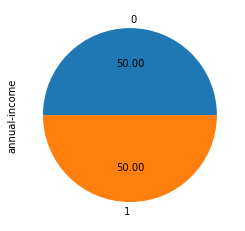

In [ ]:
Y_train.value_counts().plot.pie(autopct='%.2f')

#Where 0 is more than 50k, 1 is less than 50k

In [ ]:
sc = StandardScaler(copy=False, with_mean=False)

In [ ]:
#Use the standardized splits for the SVM models only.

pstrat_train_set = sc.fit_transform(X_train)
pstrat_test_set = sc.transform (X_test)
pstrat_valid_set = sc.transform (X_valid)

preprocessedX_train = pd.DataFrame(pstrat_train_set)
preprocessedX_test = pd.DataFrame(pstrat_test_set)
preprocessedX_valid = pd.DataFrame(pstrat_valid_set)

In [ ]:
print(X_train)

       age  workclass  fnlwgt  education  education-num  marital-status  \
11569   45          0   32356          0             13               0   
3627    61          0  197286          1              5               0   
9635    53          1  276868          2             10               0   
12796   39          0  172186          2             10               0   
105     35          0  348771          3              9               0   
...    ...        ...     ...        ...            ...             ...   
14864   64          1  341695          2             10               0   
2753    25          0   51201          3              9               0   
1146    68          0   67791          2             10               4   
1173    37          0  168941          8              7               2   
2985    38          0  216572          3              9               3   

       occupation  relationship  race  sex  capital-gain  capital-loss  \
11569           0        

In [ ]:
print(preprocessedX_train)

            0         1         2         3         4         5         6   \
0     3.501396  0.000000  0.311869  0.000000  5.072031  0.000000  0.000000   
1     4.746337  0.000000  1.901575  0.313658  1.950781  0.000000  0.279525   
2     4.123867  0.559851  2.668640  0.627317  3.901562  0.000000  0.559050   
3     3.034543  0.000000  1.659645  0.627317  3.901562  0.000000  0.559050   
4     2.723308  0.000000  3.361690  0.940975  3.511406  0.000000  0.838575   
...        ...       ...       ...       ...       ...       ...       ...   
9075  4.979763  0.559851  3.293487  0.627317  3.901562  0.000000  1.956675   
9076  1.945220  0.000000  0.493510  0.940975  3.511406  0.000000  0.279525   
9077  5.290999  0.000000  0.653415  0.627317  3.901562  4.006403  0.000000   
9078  2.878926  0.000000  1.628367  2.509267  2.731094  2.003201  0.279525   
9079  2.956735  0.000000  2.087467  0.940975  3.511406  3.004802  2.795249   

           7         8         9    10   11        12        13

In [ ]:
print(Y_train)

11569    0
3627     1
9635     0
12796    0
105      1
        ..
14864    0
2753     1
1146     1
1173     1
2985     1
Name: annual-income, Length: 9080, dtype: int64


Part 1: Train Initial Models

Training Naive Bayes, Suport Vector Machinem, Random Forest

In [ ]:
#train Naive Bayes model
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
gnb = GaussianNB()
gnb.fit(X_train ,Y_train)
#gnb.score(X_test, Y_test)

gnb_Y_train = gnb.predict(X_train)
accuracy_score(Y_train,gnb_Y_train)


0.6186123348017621

In [ ]:
#train Support Vector Machine
from sklearn import svm

clf= svm.SVC()
clf.fit(preprocessedX_train, Y_train)
#clf.score(X_test, Y_test)

svm_Y_train = clf.predict(preprocessedX_train)
accuracy_score(Y_train,svm_Y_train)

0.8288546255506608

In [ ]:
#train Random Forest
from sklearn.ensemble import RandomForestClassifier
#with n_estimators this is around 99.99
rf = RandomForestClassifier(random_state=23800756)
rf.fit(X_train, Y_train)
#rf.score(X_test, Y_test)

rf_Y_train = rf.predict(X_train)
accuracy_score(Y_train,rf_Y_train)

1.0

In [ ]:
#peformance metric functions
from sklearn.metrics import confusion_matrix, roc_auc_score, f1_score

#A list of keys for the dictionary returned by p1_metrics
metric_keys = ['auc','accuracy','sensitivity','specificity', 'precision']

def p1_metrics(y_true,y_pred,include_cm=True):
    cm = confusion_matrix(y_true,y_pred)
    tn, fp, fn, tp = cm.ravel()

    if include_cm:
        return {
            'auc': roc_auc_score(y_true,y_pred),
            'f1': f1_score(y_true,y_pred),
            'accuracy': (tp+tn)/np.sum(cm),
            'sensitivity': tp/(tp+fn),
            'specificity': tn/(tn+fp),
            'precision': tp/(tp+fp),
            'confusion_matrix': cm}
    else:
        return {
            'auc': roc_auc_score(y_true,y_pred),
            'f1': f1_score(y_true,y_pred),
            'accuracy': (tp+tn)/np.sum(cm),
            'sensitivity': tp/(tp+fn),
            'specificity': tn/(tn+fp),
            'precision': tp/(tp+fp)}

#This wrapper can be used to return multiple performance metrics during cross-validation
def p1_metrics_scorer(asd,X,y_true):
    y_pred=asd.predict(X)
    return p1_metrics(y_true,y_pred,include_cm=False)

Calculate the confusion matrix and report the following performance metrics on the training set: Accuracy, F1 Score, AUC, Sensitivity, Specificity, and Precision. You can use the function p1_metrics for this purpose. Are any of the models underfitting the data? Is so, why?

In [ ]:
p1_metrics(Y_train,gnb_Y_train,include_cm=True)

{'auc': 0.6186123348017621,
 'f1': 0.7107658899189845,
 'accuracy': 0.6186123348017621,
 'sensitivity': 0.9372246696035242,
 'specificity': 0.3,
 'precision': 0.5724471949414772,
 'confusion_matrix': array([[1362, 3178],
        [ 285, 4255]])}

model underfitted. Hard time capturing relationship and low specificity

In [ ]:
p1_metrics(Y_train,svm_Y_train,include_cm=True)

{'auc': 0.8288546255506608,
 'f1': 0.8176484393334897,
 'accuracy': 0.8288546255506608,
 'sensitivity': 0.7674008810572687,
 'specificity': 0.8903083700440528,
 'precision': 0.8749372174786539,
 'confusion_matrix': array([[4042,  498],
        [1056, 3484]])}

In [ ]:
p1_metrics(Y_train,rf_Y_train,include_cm=True)

{'auc': 1.0,
 'f1': 1.0,
 'accuracy': 1.0,
 'sensitivity': 1.0,
 'specificity': 1.0,
 'precision': 1.0,
 'confusion_matrix': array([[4540,    0],
        [   0, 4540]])}

Calculate the same metrics by applying the trained model to the validation set. Compare and contrast the errors each model makes in terms of each class.

In [ ]:
gnb_Y_pred_valid = gnb.predict(X_valid)
accuracy_score(Y_valid,gnb_Y_pred_valid)

0.6240502147340601

In [ ]:
svm_Y_pred_valid = clf.predict(preprocessedX_valid)
accuracy_score(Y_valid,svm_Y_pred_valid)

0.8202841096795507

In [ ]:
rf_Y_pred_valid = rf.predict(X_valid)
accuracy_score(Y_valid,rf_Y_pred_valid)

0.8149983481995375

In [ ]:
p1_metrics(Y_valid, gnb_Y_pred_valid,include_cm=True)

{'auc': 0.6239493303740982,
 'f1': 0.7120445344129555,
 'accuracy': 0.6240502147340601,
 'sensitivity': 0.929326287978864,
 'specificity': 0.3185723727693325,
 'precision': 0.5771123872026251,
 'confusion_matrix': array([[ 482, 1031],
        [ 107, 1407]])}

In [ ]:
p1_metrics(Y_valid, svm_Y_pred_valid,include_cm=True)

{'auc': 0.820305044523858,
 'f1': 0.8081805359661496,
 'accuracy': 0.8202841096795507,
 'sensitivity': 0.7569352708058125,
 'specificity': 0.8836748182419035,
 'precision': 0.8668683812405447,
 'confusion_matrix': array([[1337,  176],
        [ 368, 1146]])}

In [ ]:
p1_metrics(Y_valid, rf_Y_pred_valid,include_cm=True)

{'auc': 0.8150238662546786,
 'f1': 0.7995705082319255,
 'accuracy': 0.8149983481995375,
 'sensitivity': 0.73778071334214,
 'specificity': 0.8922670191672174,
 'precision': 0.87265625,
 'confusion_matrix': array([[1350,  163],
        [ 397, 1117]])}

Gaussian Naive Bayes suffered from low specificity and precision, overall performance was bad
Support Vector machine had all around good statistics, its lowest score was on the sensitivity
Random Forest did pretty well

Part 2: Cross-Validation Models

Split the non-test data (training + validation data) into stratified 5-folds for cross-validation purposes

In [ ]:
#5 folds
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5)

skf

StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

In [ ]:
#getting non test data set 80%

#non_test_data_set = pd.merge(strat_train_set_copy, strat_valid_set_copy, how="left")
non_test_data_set = strat_train_set_copy.append(strat_valid_set_copy)

X_ntd = non_test_data_set.drop(['annual-income'], axis=1)
Y_ntd = non_test_data_set['annual-income']

In [ ]:
print(non_test_data_set)

       age  workclass  fnlwgt  education  education-num  marital-status  \
11569   45          0   32356          0             13               0   
3627    61          0  197286          1              5               0   
9635    53          1  276868          2             10               0   
12796   39          0  172186          2             10               0   
105     35          0  348771          3              9               0   
...    ...        ...     ...        ...            ...             ...   
9677    36          1   52532          4             16               0   
6296    41          3  163322          9              7               1   
3394    23          4   96748          1             10               3   
2233    44          3  212894          7              6               0   
1039    23          3  444554          0              9               3   

       occupation  relationship  race  sex  capital-gain  capital-loss  \
11569           0        

Train NB, SVM, and RF models using 5-fold cross-validation.

In [ ]:

skf.get_n_splits(X_ntd, Y_ntd)

kfold = skf.split(X_ntd, Y_ntd)


In [ ]:
#Summarizes model performance results produced during cross-validation
def collate_cv_results(cv_results,display=True):
    cv_stats=dict()
    for k in cv_results:
        cv_stats["mean"]=np.mean(cv_results)
        cv_stats["std"]=np.std(cv_results)
        #if display:
            #print(k,cv_stats[k+"mean"],"("+str(cv_stats[k+"std"])+")")
    return cv_stats

In [ ]:
#using cross val score and then appending them for mean , std
from sklearn.model_selection import cross_val_score

cvresults_Gaussian = cross_val_score(GaussianNB(), X_train, Y_train)

cvlistGaus = []

for i in cvresults_Gaussian :
  cvlistGaus.append(i)

cvresults_SVC = cross_val_score(svm.SVC(), preprocessedX_train, Y_train)

cvlistSVC = []

for i in cvresults_SVC  :
  cvlistSVC.append(i)

cvresults_RF = cross_val_score(RandomForestClassifier(random_state=23800756), X_train, Y_train)

cvlistRF = []

for i in cvresults_RF :
  cvlistRF.append(i)

print(cvlistGaus, cvlistSVC, cvlistRF)


KeyboardInterrupt: ignored

In [ ]:
collate_cv_results(cvlistGaus)

In [ ]:
collate_cv_results(cvlistSVC)

In [ ]:
collate_cv_results(cvlistRF)

Across the board, using 5 fold cross validation slightly improved performance. But Naive Bayes was more consistent comparitively, because of its fairly simple classifiers

Part 3: SVM Hyperparameter Tuning

In [ ]:
#Summarizes model performance results produced during hyperparameter tuning
def collate_ht_results(ht_results,metric_keys=metric_keys,display=True):
    ht_stats=dict()
    for metric in metric_keys:
        ht_stats[metric+"_mean"] = ht_results.cv_results_["mean_test_"+metric][ht_results.best_index_]
        ht_stats[metric+"_std"] = metric_std = ht_results.cv_results_["std_test_"+metric][ht_results.best_index_]
        if display:
            print("test_"+metric,ht_stats[metric+"_mean"],"("+str(ht_stats[metric+"_std"])+")")
    return ht_stats

In [ ]:
from sklearn.metrics import classification_report

model = svm.SVC()
model.fit(preprocessedX_train, Y_train)

# print prediction results
predictions = model.predict(preprocessedX_train)

print(classification_report(Y_train, predictions))


In [ ]:
print(preprocessedX_train)

            0         1         2         3         4         5         6   \
0     3.501396  0.000000  0.311869  0.000000  5.072031  0.000000  0.000000   
1     4.746337  0.000000  1.901575  0.313658  1.950781  0.000000  0.279525   
2     4.123867  0.559851  2.668640  0.627317  3.901562  0.000000  0.559050   
3     3.034543  0.000000  1.659645  0.627317  3.901562  0.000000  0.559050   
4     2.723308  0.000000  3.361690  0.940975  3.511406  0.000000  0.838575   
...        ...       ...       ...       ...       ...       ...       ...   
9075  4.979763  0.559851  3.293487  0.627317  3.901562  0.000000  1.956675   
9076  1.945220  0.000000  0.493510  0.940975  3.511406  0.000000  0.279525   
9077  5.290999  0.000000  0.653415  0.627317  3.901562  4.006403  0.000000   
9078  2.878926  0.000000  1.628367  2.509267  2.731094  2.003201  0.279525   
9079  2.956735  0.000000  2.087467  0.940975  3.511406  3.004802  2.795249   

           7         8         9    10   11        12        13

In [ ]:
%%time

from sklearn.model_selection import GridSearchCV



param_grid = {'C': [1, 5, 10, 20],
              'gamma': ['auto','scale'],
              'kernel': ['linear', 'rbf']}

bestchoiceGSSVM = GridSearchCV(clf, param_grid, refit = 'auc', scoring = p1_metrics_scorer, cv = skf, n_jobs = 6, return_train_score = False)

grid_result = bestchoiceGSSVM.fit(preprocessedX_train, Y_train)



CPU times: user 5.83 s, sys: 434 ms, total: 6.27 s
Wall time: 5min 33s


In [ ]:
collate_ht_results(bestchoiceGSSVM, display=True)

# Print the best accuracy score for the training dataset
print(f'The best accuracy score for the training dataset is {grid_result.best_score_:.4f}')

# Print the hyperparameters for the best score
print(f'The best hyperparameters are {grid_result.best_params_}')

# Print the best accuracy score for the testing dataset
print(f'The accuracy score for the testing dataset is {bestchoiceGSSVM.score(preprocessedX_test, Y_test):.4f}')

#The best hyperparameters are {'C': 5, 'gamma': 'scale', 'kernel': 'rbf'}

In [ ]:
print(bestchoiceGSSVM.best_estimator_)

bestchoiceGSSVM_predictions = bestchoiceGSSVM.predict(preprocessedX_train)
print(classification_report(Y_train, bestchoiceGSSVM_predictions))

In [ ]:
%%time

from sklearn.model_selection import RandomizedSearchCV

param_grid2 = {'C': [1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100],
              'gamma': ['auto','scale'],
              'kernel': ['linear', 'rbf']}

randomizedSearchCVSVM = RandomizedSearchCV(clf, param_grid2, refit = 'auc', scoring = p1_metrics_scorer, cv = skf, n_jobs = 10, return_train_score = False, n_iter = 16)

random_result = randomizedSearchCVSVM.fit(preprocessedX_train, Y_train)

In [ ]:
collate_ht_results(randomizedSearchCVSVM, display=True)

# Print the best accuracy score for the training dataset
print(f'The best accuracy score for the training dataset is {random_result.best_score_:.4f}')

# Print the hyperparameters for the best score
print(f'The best hyperparameters are {random_result.best_params_}')

# Print the best accuracy score for the testing dataset
print(f'The accuracy score for the testing dataset is {randomizedSearchCVSVM.score(preprocessedX_test, Y_test):.4f}')

#The best hyperparameters are {'kernel': 'rbf', 'gamma': 'scale', 'C': 1}

In [ ]:
print(randomizedSearchCVSVM.best_estimator_)

randomizedSearchCVSVM_predictions = randomizedSearchCVSVM.predict(preprocessedX_train)
print(classification_report(Y_train, randomizedSearchCVSVM_predictions))

Gridsearch took 5 minutes while Randomized search took around 18 minutes. For the far greater computational requirement, Gridsearch still had a very slightly better result so in this case gridsearch cross validation seemed to be the better choice for hyperparameter tuning

Part 4: Random Forest Hyperparameter Tuning

In [ ]:
%%time
import math

param_grid3 = {'criterion': ['gini', 'entropy'],
              'max_depth': [math.ceil(math.log2(len(non_test_data_set))-1), None ],
              'n_estimators': [10,20,30,40,50,60,70,80,90,100]}


randm_src = RandomizedSearchCV(rf, param_grid3, refit = 'auc', scoring = p1_metrics_scorer, cv = skf, n_jobs = 6, return_train_score = False, n_iter = 16, verbose = 2)

rfht = randm_src.fit(preprocessedX_train, Y_train)



In [ ]:
print(" Results from Random Search " )
print("\n The best estimator across ALL searched params:\n", randm_src.best_estimator_)
print("\n The best score across ALL searched params:\n", randm_src.best_score_)
print("\n The best parameters across ALL searched params:\n", randm_src.best_params_)

# RandomForestClassifier(criterion='entropy', max_depth=13, n_estimators=90,random_state=23800756)

In [ ]:
collate_ht_results(randm_src)

Part 2's model performed 0.005 worse putting the random forest hyperparameter tuning model just slightly in front

Part 5:  Feature Selection

In [ ]:
sssplit3 = StratifiedShuffleSplit(n_splits=2, test_size=0.166666666, random_state=23800756)
for train_index, feature_index in sssplit3.split(strat_train_set_copy, strat_train_set_copy['annual-income']):
    split_strat_train_set = strat_train_set_copy.iloc[train_index]
    feature_set = strat_train_set_copy.iloc[feature_index]

In [ ]:
#Calculate feature importance on the feature selection subset using Random Forest Feature Importance (RFFI).

feature_importance = pd.DataFrame(rf.feature_importances_, index = X_train.columns, columns = ['importance']).sort_values('importance', ascending = False)

feature_importance

In [ ]:
#Produce a bar graph showing each feature's importance and its standard deviation, as determined by RFFI, in descending order.

from matplotlib import pyplot as plt

sorted = feature_importance.sort_values(['importance'])

plt.barh(sorted.index, sorted.importance )

plt.rcParams["figure.figsize"] = (15, 10)

In [ ]:
#Choosing the top 6 features, train NB, SVM, and RF models on this new,smaller training set and test on the validation set.

SX_train = split_strat_train_set.drop(['annual-income', 'race', 'native-country', 'sex', 'capital-loss', 'workclass', 'education', 'occupation', 'hours-per-week'], axis=1)
SY_train = split_strat_train_set['annual-income']
SX_test = X_test.drop(['race', 'native-country', 'sex', 'capital-loss', 'workclass', 'education', 'occupation', 'hours-per-week'], axis=1)
SY_test = strat_test_set_copy['annual-income']
SX_valid = X_valid.drop([ 'race', 'native-country', 'sex', 'capital-loss', 'workclass', 'education', 'occupation', 'hours-per-week'], axis=1)
SY_valid = strat_valid_set_copy['annual-income']


In [ ]:
gnb.fit(SX_train ,SY_train)

Y_predict_gnb_1 = gnb.predict(SX_valid)
accuracy_score(SY_valid,Y_predict_gnb_1)

In [ ]:
clf.fit(SX_train, SY_train)

Y_predict_svm_1 = clf.predict(SX_valid)
accuracy_score(SY_valid, Y_predict_svm_1)

In [ ]:
rf.fit(SX_train, SY_train)

rf_Y_train_1 = rf.predict(SX_valid)
accuracy_score(SY_valid,rf_Y_train_1)

In [ ]:
#Choosing the top 11 features, train NB, SVM, and RF models on this new,smaller training set and test on the validation set.

newSX_train = split_strat_train_set.drop(['annual-income', 'race', 'native-country', 'sex'], axis=1)
newSY_train = split_strat_train_set['annual-income']
newSX_valid = strat_valid_set_copy(['annual-income','race', 'native-country', 'sex'], axis=1)
newSY_valid = strat_valid_set_copy['annual-income']

In [ ]:
gnb.fit(newSX_train ,newSY_train)

Y_predict_gnb_2 = gnb.predict(newSX_valid)
accuracy_score(newSY_valid,Y_predict_gnb_2)

In [ ]:
clf.fit(newSX_train, newSY_train)

Y_predict_svm_2 = clf.predict(newSX_valid)
accuracy_score(newSY_valid, Y_predict_svm_2)

In [ ]:
rf.fit(newSX_train, newSY_train)

Y_predict_rf_2 = rf.predict(newSX_valid)
accuracy_score(newSY_valid,Y_predict_rf_2)

The performance overall was better with more features. (although im sure thats not suppose to happen). With all 14 performing better than having 11 and 6 feature models underperforming.

Part 6: Final Models and Visualization

Using the full training set (feature selection + training + validation), train NB, SVM, and RF models, then apply them to the test set. Your final NB, SVM, and RF models should be named gnb_final, svm_final, and rf_final.


In [ ]:
gnb_final = GaussianNB()

gnb_final.fit(X_ntd ,Y_ntd)

final_gnb_predict = gnb_final.predict(X_test)
accuracy_score(Y_test,final_gnb_predict)

In [ ]:
clf_final = svm.SVC(kernel= 'rbf', gamma = 'scale', C = 1, probability=True)

clf_final.fit(X_ntd, Y_ntd)

final_clf_predict = clf_final.predict(X_test)
accuracy_score(Y_test,final_clf_predict)

In [ ]:
rf_final = RandomForestClassifier(criterion='entropy', max_depth=13, n_estimators=90, random_state=23800756)


rf_final.fit(X_ntd, Y_ntd)
#rf.score(X_test, Y_test)

final_rf_predict = rf_final.predict(X_test)
accuracy_score(Y_test,final_rf_predict)

In [ ]:
#Cross validation

cvresults_Gaussian = cross_val_score(gnb_final, X_ntd, Y_ntd, cv= skf)

gnb_finalscores = []

for i in cvresults_Gaussian :
  gnb_finalscores.append(i)

cvresults_SVC = cross_val_score(clf_final, X_ntd, Y_ntd, cv= skf)

clf_finalscores = []

for i in cvresults_SVC  :
  clf_finalscores.append(i)

cvresults_RF = cross_val_score(rf_final, X_ntd, Y_ntd, cv= skf)

rf_finalscores = []

for i in cvresults_RF :
  rf_finalscores.append(i)

print(gnb_finalscores, clf_finalscores, rf_finalscores)


In [ ]:
data1 = list(gnb_finalscores.items())

In [ ]:
gnb_finalscores

In [ ]:
clf_finalscores

In [ ]:
rf_finalscores

In [ ]:
collate_cv_results(gnb_finalscores, display = True)

In [ ]:
collate_cv_results(clf_finalscores,display=True)

In [ ]:
collate_cv_results(rf_finalscores,display=True)

Create a bar chart of mean metrics from cross-validation, with standard deviation as an error bar for each model on the same plot. Use the NB model from Part 2, but the optimal models from Parts 3 and 4 for SVM and RF respectively.

In [ ]:
qwe = ['NB','SVM','RF']
mean = [collate_cv_results(cvlistGaus).get('mean'), collate_cv_results(clf_finalscores,display=True).get('mean'), collate_cv_results(rf_finalscores,display=True).get('mean')]
stndeviation = [collate_cv_results(cvlistGaus).get('std'), collate_cv_results(clf_finalscores,display=True).get('std'), collate_cv_results(rf_finalscores,display=True).get('std')]

qwe_axis = np.arange(len(qwe))

plt.bar(qwe_axis - 0.2, stndeviation, 0.4, label = 'stndeviation',)
plt.bar(qwe_axis + 0.2, mean, 0.4, label = 'mean', color = 'green')

plt.xticks(qwe_axis, qwe)
plt.legend()
plt.show()

NameError: ignored

Plot Receiver Operating Characteristic (ROC) curves for each final model in a single plot.

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

r_probs = [0 for _ in range(len(Y_test))]
gnb_probs = gnb_final.predict_proba(X_test)
svm_probs = clf_final.predict_proba(X_test)
rf_probs = rf.predict_proba(X_test)

gnb_probs = gnb_probs[:, 1]
rf_probs = rf_probs[:, 1]
svm_probs = svm_probs[:, 1]


r_auc = roc_auc_score(Y_test, r_probs)
gnb_auc = roc_auc_score(Y_test, gnb_probs)
svm_auc = roc_auc_score(Y_test, svm_probs)
rf_auc = roc_auc_score(Y_test, rf_probs)



In [ ]:
print('Random (chance) Prediction: AUROC = %.3f' % (r_auc))
print('Naive Bayes: AUROC = %.3f' % (gnb_auc))
print('Support Vector Machine: AUROC = %.3f' % (gnb_auc))
print('Random Forest: AUROC = %.3f' % (rf_auc))

In [ ]:
r_fpr, r_tpr, _ = roc_curve(Y_test, r_probs)
gnb_fpr, gnb_tpr, _ = roc_curve(Y_test, gnb_probs)
svm_fpr, svm_tpr, _ = roc_curve(Y_test, svm_probs)
rf_fpr, rf_tpr, _ = roc_curve(Y_test, rf_probs)


In [ ]:
plt.plot(r_fpr, r_tpr, linestyle='--', label='Random prediction (AUROC = %0.3f)' % r_auc)
plt.plot(gnb_fpr, gnb_tpr, marker='.', label='Naive Bayes (AUROC = %0.3f)' % gnb_auc)
plt.plot(svm_fpr, svm_tpr, marker='.', label='Support Vector Machine (AUROC = %0.3f)' % svm_auc)
plt.plot(rf_fpr, rf_tpr, marker='.', label='Random Forest (AUROC = %0.3f)' % rf_auc)


plt.title('ROC Plot')
plt.xlabel('False Positive Rate (fallout)')
plt.ylabel('True Positive Rate (recall) ')
plt.legend()
plt.show()

The AUROC is a pretty good metric for performance as it tells you how good a model's ability to discriminate between positive examples and negative examples.The AUROC for each models seemed to overall show how these three models tend to perform comparatively with each other throughout the project.